In [30]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
sc.stop()

In [2]:
spark.stop()

In [3]:
from pyspark import SparkConf, SparkContext

config = SparkConf().setAppName("SQLAssignmentSession")
sc = SparkContext(conf=config)

In [4]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName('SQLAssignmentSession').getOrCreate()

In [5]:
spark

In [6]:
churn_df = spark.read.csv('file:///home/hadoop/Downloads/Telco_Customer_Churn.csv', 
                            header=True,
                            inferSchema=True)

In [7]:
churn_df.printSchema

<bound method DataFrame.printSchema of DataFrame[customerID: string, gender: string, SeniorCitizen: int, Partner: string, Dependents: string, tenure: int, PhoneService: string, MultipleLines: string, InternetService: string, OnlineSecurity: string, OnlineBackup: string, DeviceProtection: string, TechSupport: string, StreamingTV: string, StreamingMovies: string, Contract: string, PaperlessBilling: string, PaymentMethod: string, MonthlyCharges: double, TotalCharges: string, Churn: string]>

In [8]:
from pyspark.sql.functions import col, sum

null_counts = churn_df.select([sum(col(c).isNull().cast("int")).alias(c) for c in churn_df.columns])
null_counts.collect()

[Row(customerID=0, gender=0, SeniorCitizen=0, Partner=0, Dependents=0, tenure=0, PhoneService=0, MultipleLines=0, InternetService=0, OnlineSecurity=0, OnlineBackup=0, DeviceProtection=0, TechSupport=0, StreamingTV=0, StreamingMovies=0, Contract=0, PaperlessBilling=0, PaymentMethod=0, MonthlyCharges=0, TotalCharges=0, Churn=0)]

In [9]:
churn_df.createOrReplaceTempView('churn_data')

In [26]:
spark.sql("""
SELECT count(*) as rows
FROM churn_data
""").show()

spark.sql(f"""
 SHOW COLUMNS IN churn_data
""").show()

+----+
|rows|
+----+
|7043|
+----+

+----------------+
|        col_name|
+----------------+
|      customerID|
|          gender|
|   SeniorCitizen|
|         Partner|
|      Dependents|
|          tenure|
|    PhoneService|
|   MultipleLines|
| InternetService|
|  OnlineSecurity|
|    OnlineBackup|
|DeviceProtection|
|     TechSupport|
|     StreamingTV|
| StreamingMovies|
|        Contract|
|PaperlessBilling|
|   PaymentMethod|
|  MonthlyCharges|
|    TotalCharges|
+----------------+
only showing top 20 rows



#### a) Analyze how customer retention varies based on how long the customer has stayed with the company (tenure).

In [62]:
churn_rate_df = spark.sql("""
SELECT 
    tenure,
    COUNT(*) AS total_customers,
    SUM(CASE WHEN Churn = 'Yes' THEN 1 ELSE 0 END) AS churned_customers,
    SUM(CASE WHEN Churn = 'Yes' THEN 1 ELSE 0 END) / COUNT(*) AS churn_rate
FROM churn_data
GROUP BY tenure
ORDER BY tenure
""")

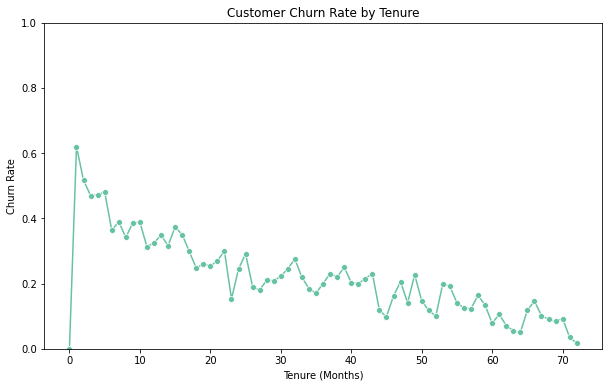

In [63]:
churn_rate_pd = churn_rate_df.toPandas()

plt.figure(figsize=(10, 6))
sns.lineplot(x='tenure', y='churn_rate', data=churn_rate_pd, marker='o')

plt.title('Customer Churn Rate by Tenure')
plt.xlabel('Tenure (Months)')
plt.ylabel('Churn Rate')
plt.ylim(0, 1)  

plt.show()

**Insights**
- We can see that the churn rate is quite high(0.8) during the initial 0-5 months, which indicates most of the users may stop the service shortly after signing up
- But after the first months, there is a sharp decline the churn rate, around the 10 month the decline stabilices, indicating long term users.

#### b) Investigate the churn rate of customers who subscribe to streaming services like StreamingTV and StreamingMovies.

In [67]:

churn_streaming_df = spark.sql("""
SELECT 
    CASE 
        WHEN StreamingTV = 'Yes' AND StreamingMovies = 'Yes' THEN 'Both StreamingTV and StreamingMovies'
        WHEN StreamingTV = 'Yes' THEN 'Only StreamingTV'
        WHEN StreamingMovies = 'Yes' THEN 'Only StreamingMovies'
        ELSE 'No Streaming Services'
    END AS streaming_service_group,
    COUNT(*) AS total_customers,
    SUM(CASE WHEN Churn = 'Yes' THEN 1 ELSE 0 END) AS churned_customers,
    SUM(CASE WHEN Churn = 'Yes' THEN 1 ELSE 0 END) / COUNT(*) AS churn_rate
FROM churn_data
WHERE InternetService != 'No'
GROUP BY streaming_service_group
ORDER BY streaming_service_group
""")

churn_streaming_df.show()


+-----------------------+---------------+-----------------+-------------------+
|streaming_service_group|total_customers|churned_customers|         churn_rate|
+-----------------------+---------------+-----------------+-------------------+
|   Both StreamingTV ...|           1940|              571| 0.2943298969072165|
|   No Streaming Serv...|           2018|              695|  0.344400396432111|
|   Only StreamingMovies|            792|              247|0.31186868686868685|
|       Only StreamingTV|            767|              243|0.31681877444589307|
+-----------------------+---------------+-----------------+-------------------+



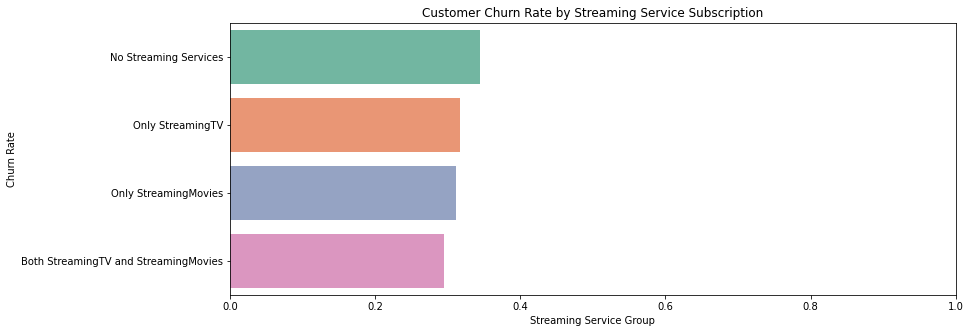

In [68]:

churn_streaming_pd = churn_streaming_df.toPandas()
churn_streaming_pd = churn_streaming_pd.sort_values(by='churn_rate', ascending=False)


sns.set_palette("Set2")  

plt.figure(figsize=(13, 5))
sns.barplot(y='streaming_service_group', x='churn_rate', data=churn_streaming_pd)

plt.title('Customer Churn Rate by Streaming Service Subscription')
plt.xlabel('Streaming Service Group')
plt.ylabel('Churn Rate')
plt.xlim(0, 1)  

plt.show()

**Insights**
- churn rate is higher in customers of streaming movies

#### c) Write Spark SQL to group customers by their tenure (e.g., 0-12 months, 13-24 months, etc.) and analyze churn rates in these tenure groups.

In [59]:

churn_tenure_df = spark.sql("""
SELECT 
    CASE 
        WHEN tenure <= 12 THEN '0-12 Months'
        WHEN tenure > 12 AND tenure <= 24 THEN '13-24 Months'
        WHEN tenure > 24 AND tenure <= 36 THEN '25-36 Months'
        WHEN tenure > 36 AND tenure <= 48 THEN '37-48 Months'
        ELSE '49+ Months'
    END AS tenure_group,
    COUNT(*) AS total_customers,
    SUM(CASE WHEN Churn = 'Yes' THEN 1 ELSE 0 END) AS churned_customers,
    SUM(CASE WHEN Churn = 'Yes' THEN 1 ELSE 0 END) / COUNT(*) AS churn_rate
FROM churn_data
GROUP BY tenure_group
ORDER BY tenure_group
""")

churn_tenure_df.show()


+------------+---------------+-----------------+-------------------+
|tenure_group|total_customers|churned_customers|         churn_rate|
+------------+---------------+-----------------+-------------------+
| 0-12 Months|           2186|             1037|0.47438243366880145|
|13-24 Months|           1024|              294|        0.287109375|
|25-36 Months|            832|              180|0.21634615384615385|
|37-48 Months|            762|              145|0.19028871391076116|
|  49+ Months|           2239|              213|0.09513175524787852|
+------------+---------------+-----------------+-------------------+



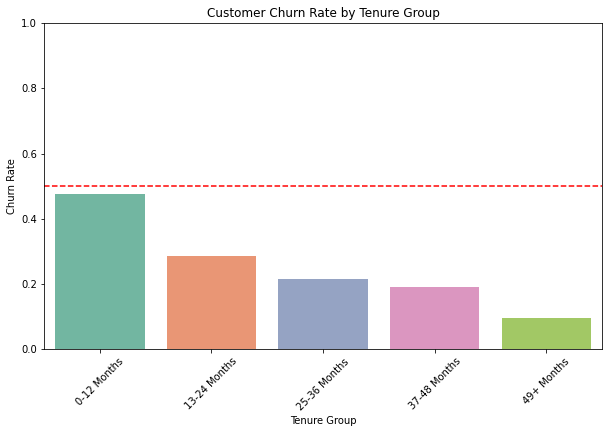

In [60]:

churn_tenure_pd = churn_tenure_df.toPandas()

plt.figure(figsize=(10, 6))
sns.barplot(x='tenure_group', y='churn_rate', data=churn_tenure_pd, palette="Set2")

plt.title('Customer Churn Rate by Tenure Group')
plt.xlabel('Tenure Group')
plt.ylabel('Churn Rate')
plt.ylim(0, 1)  
plt.axhline(y=0.5, color='r', linestyle='--')  
plt.xticks(rotation=45)

plt.show()


#### d) Analyze the impact of contract types and payment methods on churn rates.

In [64]:

contract_payment_churn_df = spark.sql(
"""
SELECT 
    Contract,
    PaymentMethod,
    COUNT(*) AS total_customers,
    SUM(CASE WHEN Churn = 'Yes' THEN 1 ELSE 0 END) AS churned_customers,
    SUM(CASE WHEN Churn = 'Yes' THEN 1 ELSE 0 END) / COUNT(*) AS churn_rate
FROM churn_data
GROUP BY Contract, PaymentMethod
ORDER BY Contract, PaymentMethod
""")

contract_payment_churn_df.show()


+--------------+--------------------+---------------+-----------------+--------------------+
|      Contract|       PaymentMethod|total_customers|churned_customers|          churn_rate|
+--------------+--------------------+---------------+-----------------+--------------------+
|Month-to-month|Bank transfer (au...|            589|              201| 0.34125636672325976|
|Month-to-month|Credit card (auto...|            543|              178|  0.3278084714548803|
|Month-to-month|    Electronic check|           1850|              994|  0.5372972972972972|
|Month-to-month|        Mailed check|            893|              282|  0.3157894736842105|
|      One year|Bank transfer (au...|            391|               38| 0.09718670076726342|
|      One year|Credit card (auto...|            398|               41| 0.10301507537688442|
|      One year|    Electronic check|            347|               64|  0.1844380403458213|
|      One year|        Mailed check|            337|               23

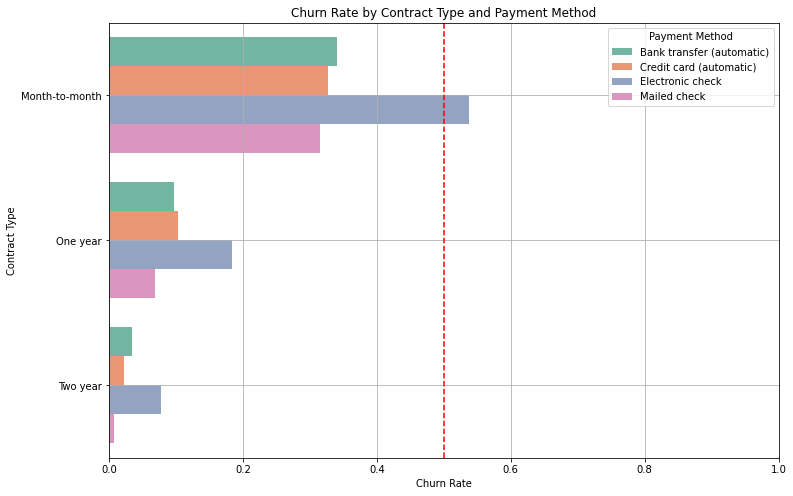

In [65]:
contract_payment_churn_pd = contract_payment_churn_df.toPandas()

plt.figure(figsize=(12, 8))
sns.barplot(x='churn_rate', y='Contract', hue='PaymentMethod', data=contract_payment_churn_pd, palette='Set2')

plt.title('Churn Rate by Contract Type and Payment Method')
plt.xlabel('Churn Rate')
plt.ylabel('Contract Type')
plt.xlim(0, 1) 

plt.axvline(x=0.5, color='r', linestyle='--') 
plt.legend(title='Payment Method')
plt.grid()
plt.show()


#### e) Explore the distribution of monthly charges for customers based on their type of internet service.

#### f) Identify the top 10 customers who have contributed the most revenue to the company, based on total charges.

#### g) Calculate the churn rate segmented by gender and whether the customer is a senior citizen.

#### h) Write query to calculate Correlation between dependents and churn. Explore whether having dependents affects customer churn rates.

#### i) Predict potential churn rates by analyzing the relationship between monthly charges, contract types, and the churn rate.

#### j) Determine the churn rate for customers who have multiple services (Phone, Internet, and Streaming), which can help understand whether bundling services leads to higher or lower churn. Calculate churn rate for customers with multiple services.

#### k) Churn Impact by device protection and online backup services. Write query to investigate whether having device protection or online backup services affects churn rates.

#### l) Explore churn rates among customers who do not have phone service and investigate if it influences customer retention.

#### m) Understand the relationship between payment methods and contract types on customer churn. This query will help you discover which combinations are most prone to churn.

#### n) Analyze how customer churn is affected by senior citizen status and whether the customer has dependents.

#### o) Explore whether subscribing to streaming services like Streaming TV and Streaming Movies influences the churn rate.

#### p) Understand how tenure and MonthlyCharges differ between churned and non-churned customers. This can provide insights into the behavior of long-term customers.

#### q) Compare monthly charges and churn rates between newer customers and long-time customers.

#### r) What is the correlation between senior citizen status and churn rate?

#### s) Partition customers based on whether they are senior citizens and divide them into 5 groups based on tenure. (Use NTILE.)

#### t) Use PERCENT_RANK to identify the top 5% of customers by MonthlyCharges.

#### u) Find customers who fall within the top 5% of the distribution based on monthly charges. Compare total charges with the next customer in the same internet service type, based on monthly charges.

#### v) Find the top 5 customers with the highest MonthlyCharges within each Contract type.

#### w) Calculate the churn rate in each Contract type and rank the contracts by churn rate.

#### x) Perform an in-depth analysis of customers using window functions to understand customer rankings, distribution, and trends in charges and tenure.